### Calibration code for the dataset Bla bla

The calibration process applies to network setups that produce both predictions and associated uncertainty estimates. Networks are considered calibrated when the predicted uncertainties align with the actual prediction errors (e.g., RMSE). To achieve this, a transformation is applied to map uncertainty predictions to measured errors. An ideal calibration would result in a plot tightly fitting 
𝑦=𝑥, where 
𝑦 represents the error and 
𝑥 the estimated uncertainty.

Following the methodology from [1,20], we sampl 𝑘=50
predictions per input image and compute pixel-wise standard deviations 𝜎1
and 𝜎2 for the two predicted image channels 𝑐1 and 𝑐2. These serve as the uncertainty predictions. To calibrate, the uncertainties are scaled using two learnable scalars, 1 and 𝛼2. Importantly, this calibration does not alter the original predictions but learns a mapping to accurately predict the measured errors.

### Important ! 

This step requires saved model predictions! Run evaluation code first.

#### General imports

In [1]:
import os
import pooch
import tifffile
import numpy as np
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lvae_training.calibration import (
    Calibration,
    plot_calibration,
)
from careamics.lvae_training.dataset import DataSplitType

#### Experiments specific imports

In [2]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

### Define sub-experiment 

In [3]:
index = "20ms"

### Download the data

In [4]:
DATA = pooch.create(
    path="./data",
    base_url="https://download.fht.org/jug/microsplit/ht_lif24/data",
    registry={"ht_lif24.zip": None},
)

NOISE_MODELS = pooch.create(
    path="./noise_models",
    base_url=f"https://download.fht.org/jug/microsplit/ht_lif24/{index}",
    registry={
        "nm_ht_lif24_ch1_20ms.npz": None,
        "nm_ht_lif24_ch2_20ms.npz": None,
        "nm_ht_lif24_ch3_20ms.npz": None,
    },
)

MODEL_CHECKPOINTS = pooch.create(
    path="./checkpoints",
    base_url=f"https://download.fht.org/jug/microsplit/ht_lif24/{index}",
    registry={"best.ckpt": None, "last.ckpt": None},
)

In [5]:
DATA.fetch("ht_lif24.zip", processor=pooch.Unzip())

for f in MODEL_CHECKPOINTS.registry:
    MODEL_CHECKPOINTS.fetch(f"{f}")

### Get configs

In [6]:
train_data_config, val_data_config, test_data_configs = get_data_configs(
    dset_type=index
)
experiment_params = get_microsplit_parameters(
    dset_type=index, nm_path=NOISE_MODELS.path
)

### Create dataset

In [7]:
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA.path / "ht_lif24.zip.unzip/ht_lif24",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)


Loading from data/ht_lif24.zip.unzip/ht_lif24/Set1/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set2/uSplit_20ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set3/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set4/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set5/uSplit_20ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set6/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; 

### Get experiment configs

In [8]:
experiment_params["data_stats"] = data_stats  # TODO rethink

loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Load predictions

In [9]:
predictions = {}
stds = {}
for filename in os.listdir("predictions"):
    file_id = filename.split("_", maxsplit=1)[1].split(".")[0]
    if filename.startswith("std"):
        stds[file_id] = tifffile.imread(f"predictions/{filename}")
    else:
        predictions[file_id] = tifffile.imread(f"predictions/{filename}")

#### Target preparation

In [10]:
data_stats = experiment_params["data_stats"]

# Index of file to visualize
file_idx = 1

# Filename by index
filename_idx = str(test_dset._fpath).split("/")[-1].split(".")[0]
target = test_dset._data[..., :-1]
prediction = predictions[filename_idx][..., :-1]
std = stds[filename_idx][..., :-1]

sep_mean = np.transpose(data_stats[0].numpy(), axes=(0, 2, 3, 1))
sep_std = np.transpose(data_stats[1].numpy(), axes=(0, 2, 3, 1))

target_normalized = (target - sep_mean)/ sep_std

In [11]:
# NOTE: Recall the `pred_std` here is the pixel-wise std of the mmse_count many predictions
calib = Calibration(
    num_bins=30,
)
native_stats = calib.compute_stats(
    pred=prediction,
    pred_std=std,
    target=target_normalized
)
count = np.array(native_stats[0]['bin_count'])
count = count / count.sum()


/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


### Compute calibration factors


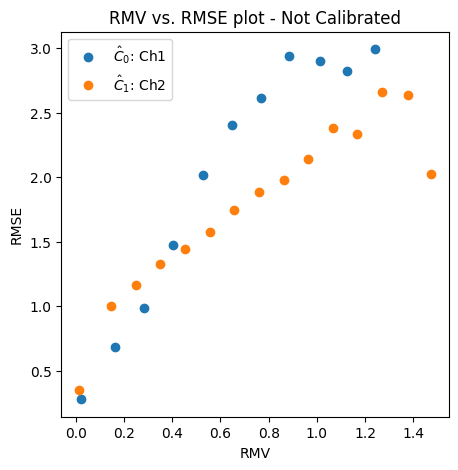

In [12]:
_,ax = plt.subplots(figsize=(5,5))
plt.title("RMV vs. RMSE plot - Not Calibrated")
plot_calibration(ax, native_stats)

### Perform calibration


In [16]:
# Compute calibration factors for the channels
calib_factors, factors_array = calib.get_calibrated_factor_for_stdev()
print(f"Calibration factors: {calib_factors}")

Calibration factors: {0: {'scalar': 0.9961809608003007, 'offset': 0.010711434527646002}, 1: {'scalar': 0.9980425907298415, 'offset': 0.004782033525940088}, 2: {'scalar': 0.9988490494167586, 'offset': 0.005105936633412966}}


### Apply calibration factors

In [17]:
# Use pre-computed calibration factor
calib = Calibration(num_bins=30)

stats = calib.compute_stats(
    prediction,
    std * factors_array["scalar"] + factors_array["offset"],
    target_normalized
)

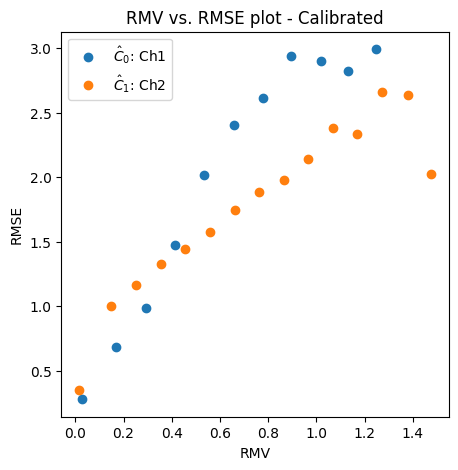

In [18]:
_,ax = plt.subplots(figsize=(5,5))
plt.title("RMV vs. RMSE plot - Calibrated")
plot_calibration(ax, stats)